In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def gaussian_data(mus, covmats, n):
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

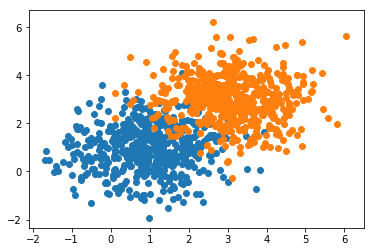

In [40]:
xy = gaussian_data(([1, 1], [3, 3]), (np.eye(2), np.eye(2)), 1000)
positive = xy[xy[:, 2] == 1]
negative = xy[xy[:, 2] == -1]
plt.scatter(positive[:, 0], positive[:, 1])
plt.scatter(negative[:, 0], negative[:, 1])
plt.show()
xmat = xy[:, :2].T
y = xy[:, 2:].T

## LossFunc class
We create here an almost empty class model for losses functions. The objective is to be able to change loss function easily

In [103]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func

We define the hinge loss using the class framework defined above

In [104]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

def vector_hinge_dual(alpha, y):
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai
    return max(-1, min(1, q)) - alpha
    
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating w(alpha) to alpha)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [89]:
def w_dot_xmat(w, xmat):
    return np.dot(np.transpose(w), xmat)

In [90]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    a = w_dot_xmat(w, xmat) 
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [91]:
def alpha_to_w(alpha, xmat, lamb):
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha.T)

In [98]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual + reg

In [102]:
# Test for those few first functions
w_test = np.array([1, 1])
w_test = w_test.reshape((2, 1))
a = w_dot_xmat(w_test, xmat)
h = vector_hinge_loss(a, y)
cumloss = cum_loss(w_test, xmat, y, 1)
n = y.shape[1]
alpha_test = 0.5 * np.ones((1, n))
cum_loss_dual(alpha_test, xmat, y, 1)

-inf

In [100]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

After optimization, we find that the optimal $\alpha_t^{\star}$ is given by : 
$$ \alpha_t^{\star} = \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

In [105]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    return ((lamb * t) / xsqrnorm) * (yt - wdotx)

hinge.set_sgd_update(hinge_sgd_update)

In [112]:
def modified_sgd(xmat, y, lamb, lossfunc=hinge):
    d = xmat.shape[0]
    n = xmat.shape[1]
    alpha = np.zeros((1, n))
    w = np.zeros((d, 1))
    for t in range(0, n):
        alpha[:, t] = lossfunc.sgd_update(w, xmat[:, t], y[0, t], lamb, t)
        w = alpha_to_w(alpha[:, :t + 1], xmat[:, :t + 1], lamb)
    return alpha       

In [114]:
alpha_test = modified_sgd(xmat, y, 1)
alpha_test

array([[  0.00000000e+00,  -5.19613592e-02,   3.24225186e-01,
          1.66216357e-01,  -2.62007651e-01,  -5.69843640e-02,
          9.42718431e-03,   2.44567137e+00,   7.58056705e-01,
         -1.07168006e+00,   1.12787457e+00,   5.80847941e+00,
         -1.68827701e+00,  -2.58788514e-02,  -4.52936805e-01,
          1.85334597e+00,   1.31884049e+00,  -3.74187022e+00,
          4.18943840e+00,  -2.07368714e+00,   9.83395945e+00,
          1.38418081e+00,  -3.75473647e+00,  -2.26382750e+00,
          2.42616155e+01,   6.38973703e+00,  -8.79255049e+00,
         -8.03699804e-02,   4.08763346e+01,  -4.37858734e+00,
          3.88493552e+01,  -6.88116065e+00,   6.83014226e+01,
          1.28630982e+01,  -1.64294112e+01,  -8.19570680e+00,
          1.30621898e+01,  -5.16004108e+00,   7.19572420e+00,
          2.50816145e+00,   8.83420926e+01,   8.69916869e+00,
          3.66732589e+03,  -1.52459216e+02,   4.32036622e+00,
         -4.75667607e+00,   4.00466218e+00,  -6.18645005e+00,
        